170500096/170498071 [==============================] - 4s 0us/step
x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32) 

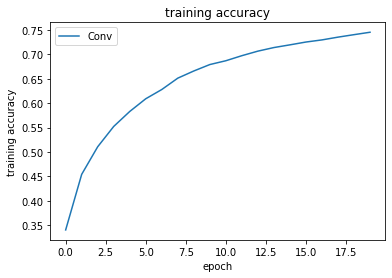

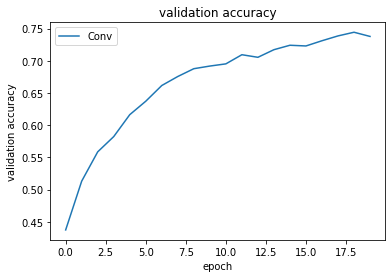

313/313 [==============================] - 1s 2ms/step - loss: 0.7785 - accuracy: 0.7364
Test accuracy: 0.7364000082015991


In [ ]:
# libraries (do not import additional libraries)
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint
import math
import matplotlib.pyplot as plt

# parameters for this script
batch_size = 32
num_classes = 10
epochs = 20
data_augmentation = False

# Load the data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# Define a convolutional neural network
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# initiate RMSprop optimizer
opt = keras.optimizers.RMSprop(lr=0.0001, decay=1e-6)

# Compile the model before using it
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
print(model.summary())

# normalize the data
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

# partition training set into training and validation set
x_validate = x_train[40000:,:]
x_train = x_train[:40000,:]
y_validate = y_train[40000:,:]
y_train = y_train[:40000,:]

# create a callback that will save the best model while training
save_best_model = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)

# train without data augmentation
if not data_augmentation:
    print('Not using data augmentation.')
    history = model.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_data=(x_validate, y_validate),
                        shuffle=True,
                        callbacks=[save_best_model])

# train with data augmentation
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    history = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
                        steps_per_epoch=math.ceil(x_train.shape[0]/batch_size),
                        epochs=epochs,
                        validation_data=(x_validate, y_validate),
                        callbacks=[save_best_model])
    
# Plot training accuracy
plt.plot(history.history['accuracy'])
plt.title('training accuracy')
plt.ylabel('training accuracy')
plt.xlabel('epoch')
plt.legend(['Conv'], loc='upper left')
plt.show()

# Plot validation accuracy
plt.plot(history.history['val_accuracy'])
plt.title('validation accuracy')
plt.ylabel('validation accuracy')
plt.xlabel('epoch')
plt.legend(['Conv'], loc='upper left')
plt.show()

# Evaluate the best model saved (i.e., model with best validation accuracy) on the test set
saved_model = load_model('best_model.h5')
scores = saved_model.evaluate(x_test, y_test, verbose=1)
print('Test accuracy:', scores[1])

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_6 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_7 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 16, 16, 32)        0         
_______________________________________________

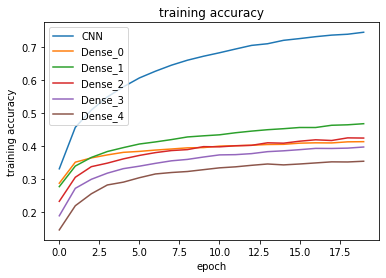

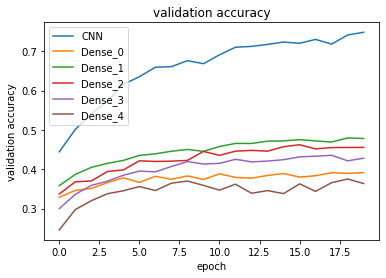

Test accuracy(CNN): 0.7397000193595886
Test accuracy(Dense_0): 0.38850000500679016
Test accuracy(Dense_1): 0.4781000018119812
Test accuracy(Dense_2): 0.4691999852657318
Test accuracy(Dense_3): 0.4401000142097473
Test accuracy(Dense_4): 0.3765999972820282


In [ ]:
# libraries (do not import additional libraries)
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint
import math
import matplotlib.pyplot as plt

# parameters for this script
batch_size = 32
num_classes = 10
epochs = 20
data_augmentation = False

# Load the data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# Define a convolutional neural network
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

###################################################
#Dense network with 0 hidden layer
model0 = Sequential()
model0.add(Flatten(input_shape=x_train.shape[1:]))

model0.add(Dense(num_classes))
model0.add(Activation('softmax'))
############################################
#Dense network with 1 hidden layer
model1 = Sequential()
model1.add(Flatten(input_shape=x_train.shape[1:]))

model1.add(Dense(512))
model1.add(Activation('relu'))
model1.add(Dropout(0.5))

model1.add(Dense(num_classes))
model1.add(Activation('softmax'))
##################################################
#Dense network with two hidden layers
model2 = Sequential()
model2.add(Flatten(input_shape=x_train.shape[1:]))

model2.add(Dense(512))
model2.add(Activation('relu'))
model2.add(Dropout(0.5))

model2.add(Dense(512))
model2.add(Activation('relu'))
model2.add(Dropout(0.5))

model2.add(Dense(num_classes))
model2.add(Activation('softmax'))
####################################################
#Dense network with 3 hidden layers
model3 = Sequential()
model3.add(Flatten(input_shape=x_train.shape[1:]))

model3.add(Dense(512))
model3.add(Activation('relu'))
model3.add(Dropout(0.5))

model3.add(Dense(512))
model3.add(Activation('relu'))
model3.add(Dropout(0.5))

model3.add(Dense(512))
model3.add(Activation('relu'))
model3.add(Dropout(0.5))

model3.add(Dense(num_classes))
model3.add(Activation('softmax'))
########################################################3
#Dense network with 4 hidden layers
model4 = Sequential()
model4.add(Flatten(input_shape=x_train.shape[1:]))

model4.add(Dense(512))
model4.add(Activation('relu'))
model4.add(Dropout(0.5))

model4.add(Dense(512))
model4.add(Activation('relu'))
model4.add(Dropout(0.5))

model4.add(Dense(512))
model4.add(Activation('relu'))
model4.add(Dropout(0.5))

model4.add(Dense(512))
model4.add(Activation('relu'))
model4.add(Dropout(0.5))

model4.add(Dense(num_classes))
model4.add(Activation('softmax'))
##########################################################
opt = keras.optimizers.RMSprop(lr=0.0001, decay=1e-6)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
print(model.summary())
###############################################
opt0 = keras.optimizers.RMSprop(lr=0.0001, decay=1e-6)
model0.compile(loss='categorical_crossentropy',
              optimizer=opt0,
              metrics=['accuracy'])
print(model0.summary())
#############################################
opt1 = keras.optimizers.RMSprop(lr=0.0001, decay=1e-6)
model1.compile(loss='categorical_crossentropy',
              optimizer=opt1,
              metrics=['accuracy'])
print(model1.summary())
#############################################
opt2 = keras.optimizers.RMSprop(lr=0.0001, decay=1e-6)
model2.compile(loss='categorical_crossentropy',
              optimizer=opt2,
              metrics=['accuracy'])
print(model2.summary())
##############################################
opt3 = keras.optimizers.RMSprop(lr=0.0001, decay=1e-6)
model3.compile(loss='categorical_crossentropy',
              optimizer=opt3,
              metrics=['accuracy'])
print(model3.summary())
###########################################
opt4 = keras.optimizers.RMSprop(lr=0.0001, decay=1e-6)
model4.compile(loss='categorical_crossentropy',
              optimizer=opt4,
              metrics=['accuracy'])
print(model4.summary())
#############################################







# normalize the data
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

# partition training set into training and validation set
x_validate = x_train[40000:,:]
x_train = x_train[:40000,:]
y_validate = y_train[40000:,:]
y_train = y_train[:40000,:]

# create a callback that will save the best model while training
save_best_model  = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', save_best_only=True, verbose=0)
save_best_model0 = ModelCheckpoint('best_model0.h5', monitor='val_accuracy', mode='max', save_best_only=True, verbose=0)
save_best_model1 = ModelCheckpoint('best_model1.h5', monitor='val_accuracy', mode='max', save_best_only=True, verbose=0)
save_best_model2 = ModelCheckpoint('best_model2.h5', monitor='val_accuracy', mode='max', save_best_only=True, verbose=0)
save_best_model3 = ModelCheckpoint('best_model3.h5', monitor='val_accuracy', mode='max', save_best_only=True, verbose=0)
save_best_model4 = ModelCheckpoint('best_model4.h5', monitor='val_accuracy', mode='max', save_best_only=True, verbose=0)

# train without data augmentation
if not data_augmentation:
    print('Not using data augmentation.')
    history = model.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_data=(x_validate, y_validate),
                        shuffle=True,
                        callbacks=[save_best_model],verbose=0)
    history0 = model0.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_data=(x_validate, y_validate),
                        shuffle=True,
                        callbacks=[save_best_model0],verbose=0)
    history1 = model1.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_data=(x_validate, y_validate),
                        shuffle=True,
                        callbacks=[save_best_model1],verbose=0)
    history2 = model2.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_data=(x_validate, y_validate),
                        shuffle=True,
                        callbacks=[save_best_model2],verbose=0)
    history3 = model3.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_data=(x_validate, y_validate),
                        shuffle=True,
                        callbacks=[save_best_model3],verbose=0)
    history4 = model4.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_data=(x_validate, y_validate),
                        shuffle=True,
                        callbacks=[save_best_model4],verbose=0)

# Plot training accuracy
plt.plot(history.history['accuracy'],label='CNN')
plt.plot(history0.history['accuracy'],label='Dense_0')
plt.plot(history1.history['accuracy'],label='Dense_1')
plt.plot(history2.history['accuracy'],label='Dense_2')
plt.plot(history3.history['accuracy'],label='Dense_3')
plt.plot(history4.history['accuracy'],label='Dense_4')
plt.title('training accuracy')
plt.ylabel('training accuracy')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.show()

# Plot validation accuracy
plt.plot(history.history['val_accuracy'],label='CNN')
plt.plot(history0.history['val_accuracy'],label='Dense_0')
plt.plot(history1.history['val_accuracy'],label='Dense_1')
plt.plot(history2.history['val_accuracy'],label='Dense_2')
plt.plot(history3.history['val_accuracy'],label='Dense_3')
plt.plot(history4.history['val_accuracy'],label='Dense_4')
plt.title('validation accuracy')
plt.ylabel('validation accuracy')
plt.xlabel('epoch')
plt.legend( loc='upper left')
plt.show()

# Evaluate the best model saved (i.e., model with best validation accuracy) on the test set
saved_model = load_model('best_model.h5')
saved_model0 = load_model('best_model0.h5')
saved_model1 = load_model('best_model1.h5')
saved_model2 = load_model('best_model2.h5')
saved_model3 = load_model('best_model3.h5')
saved_model4 = load_model('best_model4.h5')

scores = saved_model.evaluate(  x_test, y_test,   verbose=0)
scores0 = saved_model0.evaluate(x_test, y_test, verbose=0)
scores1 = saved_model1.evaluate(x_test, y_test, verbose=0)
scores2 = saved_model2.evaluate(x_test, y_test, verbose=0)
scores3 = saved_model3.evaluate(x_test, y_test, verbose=0)
scores4 = saved_model4.evaluate(x_test, y_test, verbose=0)

print('Test accuracy(CNN):', scores[1])
print('Test accuracy(Dense_0):', scores0[1])
print('Test accuracy(Dense_1):', scores1[1])
print('Test accuracy(Dense_2):', scores2[1])
print('Test accuracy(Dense_3):', scores3[1])
print('Test accuracy(Dense_4):', scores4[1])


x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_27 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_28 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 16, 16, 32)        0         
_______________________________________________

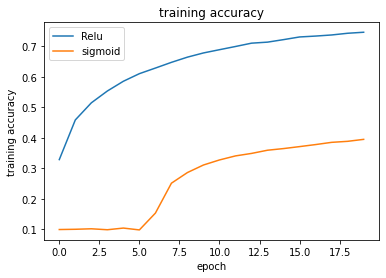

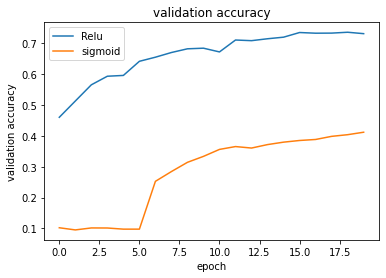

Test accuracy(Relu): 0.7285000085830688
Test accuracy(sigmoid): 0.426800012588501


In [ ]:
# libraries (do not import additional libraries)
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint
import math
import matplotlib.pyplot as plt

# parameters for this script
batch_size = 32
num_classes = 10
epochs = 20
data_augmentation = False

# Load the data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# Define a convolutional neural network
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

#################################################
# Define a convolutional neural network with sigmoid
modelsig = Sequential()
modelsig.add(Conv2D(32, (3, 3), padding='same',input_shape=x_train.shape[1:]))
modelsig.add(Activation('sigmoid'))
modelsig.add(Conv2D(32, (3, 3), padding='same'))
modelsig.add(Activation('sigmoid'))
modelsig.add(MaxPooling2D(pool_size=(2, 2)))
modelsig.add(Dropout(0.25))

modelsig.add(Conv2D(64, (3, 3), padding='same'))
modelsig.add(Activation('sigmoid'))
modelsig.add(Conv2D(64, (3, 3), padding='same'))
modelsig.add(Activation('sigmoid'))
modelsig.add(MaxPooling2D(pool_size=(2, 2)))
modelsig.add(Dropout(0.25))

modelsig.add(Flatten())
modelsig.add(Dense(512))
modelsig.add(Activation('sigmoid'))
modelsig.add(Dropout(0.5))
modelsig.add(Dense(num_classes))
modelsig.add(Activation('softmax'))


# initiate RMSprop optimizer
opt = keras.optimizers.RMSprop(lr=0.0001, decay=1e-6)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
print(model.summary())

optsig = keras.optimizers.RMSprop(lr=0.0001, decay=1e-6)
modelsig.compile(loss='categorical_crossentropy',
              optimizer=optsig,
              metrics=['accuracy'])
print(modelsig.summary())

# normalize the data
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

# partition training set into training and validation set
x_validate = x_train[40000:,:]
x_train = x_train[:40000,:]
y_validate = y_train[40000:,:]
y_train = y_train[:40000,:]

# create a callback that will save the best model while training
save_best_model = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', save_best_only=True, verbose=0)
save_best_modelsig = ModelCheckpoint('best_modelsig.h5', monitor='val_accuracy', mode='max', save_best_only=True, verbose=0)

# train without data augmentation
if not data_augmentation:
    print('Not using data augmentation.')
    history = model.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_data=(x_validate, y_validate),
                        shuffle=True,
                        callbacks=[save_best_model],verbose=0)
    historysig = modelsig.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_data=(x_validate, y_validate),
                        shuffle=True,
                        callbacks=[save_best_modelsig],verbose=0)

    
# Plot training accuracy
plt.plot(history.history['accuracy'],label='Relu')
plt.plot(historysig.history['accuracy'],label='sigmoid')
plt.title('training accuracy')
plt.ylabel('training accuracy')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.show()

# Plot validation accuracy
plt.plot(history.history['val_accuracy'],label='Relu')
plt.plot(historysig.history['val_accuracy'],label='sigmoid')
plt.title('validation accuracy')
plt.ylabel('validation accuracy')
plt.xlabel('epoch')
plt.legend( loc='upper left')
plt.show()

# Evaluate the best model saved (i.e., model with best validation accuracy) on the test set
saved_model = load_model('best_model.h5')
saved_modelsig = load_model('best_modelsig.h5')

scores = saved_model.evaluate(x_test, y_test, verbose=0)
scoressig = saved_modelsig.evaluate(x_test, y_test, verbose=0)

print('Test accuracy(Relu):', scores[1])
print('Test accuracy(sigmoid):', scoressig[1])

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
activation_28 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_29 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 16, 16, 32)        0         
_______________________________________________

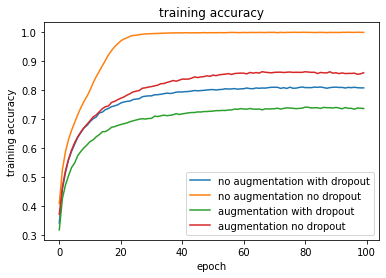

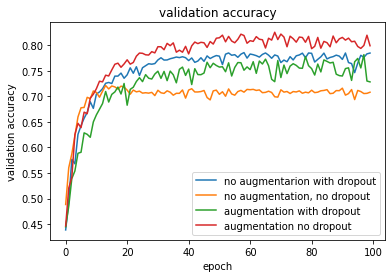

Test accuracy(no augmentation with dropout): 0.7749000191688538
Test accuracy(no augmentation no dropout): 0.7113000154495239
Test accuracy(augmentation with dropout): 0.7748000025749207
Test accuracy(augmentation no dropout): 0.8105999827384949


In [ ]:
# libraries (do not import additional libraries)
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint
import math
import matplotlib.pyplot as plt

# parameters for this script
batch_size = 32
num_classes = 10
epochs = 100
data_augmentation = False

# Load the data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
###############################################################
# Define a convolutional neural network
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# initiate RMSprop optimizer
opt = keras.optimizers.RMSprop(lr=0.0001, decay=1e-6)

# Compile the model before using it
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
print(model.summary())

###############################################
# Define a convolutional neural network
modelnodrop = Sequential()
modelnodrop.add(Conv2D(32, (3, 3), padding='same',input_shape=x_train.shape[1:]))
modelnodrop.add(Activation('relu'))
modelnodrop.add(Conv2D(32, (3, 3), padding='same'))
modelnodrop.add(Activation('relu'))
modelnodrop.add(MaxPooling2D(pool_size=(2, 2)))


modelnodrop.add(Conv2D(64, (3, 3), padding='same'))
modelnodrop.add(Activation('relu'))
modelnodrop.add(Conv2D(64, (3, 3), padding='same'))
modelnodrop.add(Activation('relu'))
modelnodrop.add(MaxPooling2D(pool_size=(2, 2)))


modelnodrop.add(Flatten())
modelnodrop.add(Dense(512))
modelnodrop.add(Activation('relu'))


modelnodrop.add(Dense(num_classes))
modelnodrop.add(Activation('softmax'))

# initiate RMSprop optimizer
optnodrop = keras.optimizers.RMSprop(lr=0.0001, decay=1e-6)

# Compile the model before using it
modelnodrop.compile(loss='categorical_crossentropy',
              optimizer=optnodrop,
              metrics=['accuracy'])
print(modelnodrop.summary())
#######################################################
modelaug = Sequential()
modelaug.add(Conv2D(32, (3, 3), padding='same',input_shape=x_train.shape[1:]))
modelaug.add(Activation('relu'))
modelaug.add(Conv2D(32, (3, 3), padding='same'))
modelaug.add(Activation('relu'))
modelaug.add(MaxPooling2D(pool_size=(2, 2)))
modelaug.add(Dropout(0.25))

modelaug.add(Conv2D(64, (3, 3), padding='same'))
modelaug.add(Activation('relu'))
modelaug.add(Conv2D(64, (3, 3), padding='same'))
modelaug.add(Activation('relu'))
modelaug.add(MaxPooling2D(pool_size=(2, 2)))
modelaug.add(Dropout(0.25))

modelaug.add(Flatten())
modelaug.add(Dense(512))
modelaug.add(Activation('relu'))
modelaug.add(Dropout(0.5))
modelaug.add(Dense(num_classes))
modelaug.add(Activation('softmax'))

optaug = keras.optimizers.RMSprop(lr=0.0001, decay=1e-6)

modelaug.compile(loss='categorical_crossentropy',
              optimizer=optaug,
              metrics=['accuracy'])
print(modelaug.summary())
###########################################################
modelaugnodrop = Sequential()
modelaugnodrop.add(Conv2D(32, (3, 3), padding='same',input_shape=x_train.shape[1:]))
modelaugnodrop.add(Activation('relu'))
modelaugnodrop.add(Conv2D(32, (3, 3), padding='same'))
modelaugnodrop.add(Activation('relu'))
modelaugnodrop.add(MaxPooling2D(pool_size=(2, 2)))


modelaugnodrop.add(Conv2D(64, (3, 3), padding='same'))
modelaugnodrop.add(Activation('relu'))
modelaugnodrop.add(Conv2D(64, (3, 3), padding='same'))
modelaugnodrop.add(Activation('relu'))
modelaugnodrop.add(MaxPooling2D(pool_size=(2, 2)))


modelaugnodrop.add(Flatten())
modelaugnodrop.add(Dense(512))
modelaugnodrop.add(Activation('relu'))

modelaugnodrop.add(Dense(num_classes))
modelaugnodrop.add(Activation('softmax'))

optaugnodrop = keras.optimizers.RMSprop(lr=0.0001, decay=1e-6)

modelaugnodrop.compile(loss='categorical_crossentropy',
              optimizer=optaugnodrop,
              metrics=['accuracy'])
print(modelaugnodrop.summary())
##########################################################

# normalize the data
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

# partition training set into training and validation set
x_validate = x_train[40000:,:]
x_train = x_train[:40000,:]
y_validate = y_train[40000:,:]
y_train = y_train[:40000,:]

# create a callback that will save the best model while training
save_best_model = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', save_best_only=True, verbose=0)
save_best_modelnodrop = ModelCheckpoint('best_modelnodrop.h5', monitor='val_accuracy', mode='max', save_best_only=True, verbose=0)
save_best_modelaug = ModelCheckpoint('best_modelaug.h5', monitor='val_accuracy', mode='max', save_best_only=True, verbose=0)
save_best_modelaugnodrop = ModelCheckpoint('best_modelaugnodrop.h5', monitor='val_accuracy', mode='max', save_best_only=True, verbose=0)

# train without data augmentation
if not data_augmentation:
    print('Not using data augmentation.')
    history = model.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_data=(x_validate, y_validate),
                        shuffle=True,
                        callbacks=[save_best_model],verbose=0)
    historynodrop = modelnodrop.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_data=(x_validate, y_validate),
                        shuffle=True,
                        callbacks=[save_best_modelnodrop],verbose=0)


# train with data augmentation
if (True):
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    historyaug = modelaug.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
                        steps_per_epoch=math.ceil(x_train.shape[0]/batch_size),
                        epochs=epochs,
                        validation_data=(x_validate, y_validate),
                        callbacks=[save_best_modelaug],verbose=0)
    historyaugnodrop = modelaugnodrop.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
                        steps_per_epoch=math.ceil(x_train.shape[0]/batch_size),
                        epochs=epochs,
                        validation_data=(x_validate, y_validate),
                        callbacks=[save_best_modelaugnodrop],verbose=0)
    
# Plot training accuracy
plt.plot(history.history['accuracy'],label='no augmentation with dropout')
plt.plot(historynodrop.history['accuracy'],label='no augmentation no dropout')
plt.plot(historyaug.history['accuracy'],label='augmentation with dropout')
plt.plot(historyaugnodrop.history['accuracy'],label='augmentation no dropout')
plt.title('training accuracy')
plt.ylabel('training accuracy')
plt.xlabel('epoch')
plt.legend(loc='lower right')
plt.show()

# Plot validation accuracy
plt.plot(history.history['val_accuracy'],label='no augmentarion with dropout')
plt.plot(historynodrop.history['val_accuracy'],label='no augmentation, no dropout')
plt.plot(historyaug.history['val_accuracy'],label='augmentation with dropout')
plt.plot(historyaugnodrop.history['val_accuracy'],label='augmentation no dropout')
plt.title('validation accuracy')
plt.ylabel('validation accuracy')
plt.xlabel('epoch')
plt.legend(loc='lower right')
plt.show()

# Evaluate the best model saved (i.e., model with best validation accuracy) on the test set
saved_model = load_model('best_model.h5')
saved_modelnodrop = load_model('best_modelnodrop.h5')
saved_modelaug = load_model('best_modelaug.h5')
saved_modelaugnodrop = load_model('best_modelaugnodrop.h5')

scores = saved_model.evaluate(x_test, y_test, verbose=0)
scoresnodrop = saved_modelnodrop.evaluate(x_test, y_test, verbose=0)
scoresaug = saved_modelaug.evaluate(x_test, y_test, verbose=0)
scoresaugnodrop = saved_modelaugnodrop.evaluate(x_test, y_test, verbose=0)

print('Test accuracy(no augmentation with dropout):', scores[1])
print('Test accuracy(no augmentation no dropout):', scoresnodrop[1])
print('Test accuracy(augmentation with dropout):', scoresaug[1])
print('Test accuracy(augmentation no dropout):', scoresaugnodrop[1])

170500096/170498071 [==============================] - 4s 0us/step
x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32) 

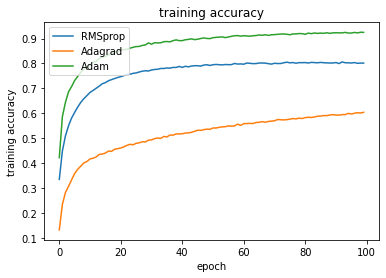

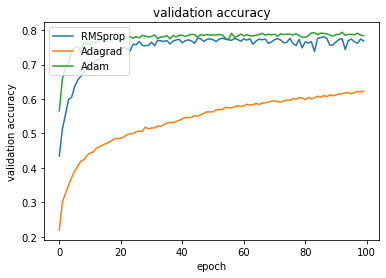

Test accuracy(RMSprop): 0.775600016117096
Test accuracy(Adagrad): 0.6202999949455261
Test accuracy(Adam): 0.7821000218391418


In [ ]:
# libraries (do not import additional libraries)
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint
import math
import matplotlib.pyplot as plt

# parameters for this script
batch_size = 32
num_classes = 10
epochs = 100
data_augmentation = False

# Load the data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# Define a convolutional neural network
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# initiate RMSprop optimizer
opt = keras.optimizers.RMSprop(lr=0.0001, decay=1e-6)

# Compile the model before using it
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
print(model.summary())

###############################################
# Define a convolutional neural network
modelgrad = Sequential()
modelgrad.add(Conv2D(32, (3, 3), padding='same',input_shape=x_train.shape[1:]))
modelgrad.add(Activation('relu'))
modelgrad.add(Conv2D(32, (3, 3), padding='same'))
modelgrad.add(Activation('relu'))
modelgrad.add(MaxPooling2D(pool_size=(2, 2)))
modelgrad.add(Dropout(0.25))

modelgrad.add(Conv2D(64, (3, 3), padding='same'))
modelgrad.add(Activation('relu'))
modelgrad.add(Conv2D(64, (3, 3), padding='same'))
modelgrad.add(Activation('relu'))
modelgrad.add(MaxPooling2D(pool_size=(2, 2)))
modelgrad.add(Dropout(0.25))

modelgrad.add(Flatten())
modelgrad.add(Dense(512))
modelgrad.add(Activation('relu'))
modelgrad.add(Dropout(0.5))
modelgrad.add(Dense(num_classes))
modelgrad.add(Activation('softmax'))

# initiate RMSprop optimizer
optgrad = keras.optimizers.Adagrad()

# Compile the model before using it
modelgrad.compile(loss='categorical_crossentropy',
              optimizer=optgrad,
              metrics=['accuracy'])
print(modelgrad.summary())

##############################################

# Define a convolutional neural network
modeladam = Sequential()
modeladam.add(Conv2D(32, (3, 3), padding='same',input_shape=x_train.shape[1:]))
modeladam.add(Activation('relu'))
modeladam.add(Conv2D(32, (3, 3), padding='same'))
modeladam.add(Activation('relu'))
modeladam.add(MaxPooling2D(pool_size=(2, 2)))
modeladam.add(Dropout(0.25))

modeladam.add(Conv2D(64, (3, 3), padding='same'))
modeladam.add(Activation('relu'))
modeladam.add(Conv2D(64, (3, 3), padding='same'))
modeladam.add(Activation('relu'))
modeladam.add(MaxPooling2D(pool_size=(2, 2)))
modeladam.add(Dropout(0.25))

modeladam.add(Flatten())
modeladam.add(Dense(512))
modeladam.add(Activation('relu'))
modeladam.add(Dropout(0.5))
modeladam.add(Dense(num_classes))
modeladam.add(Activation('softmax'))

# initiate RMSprop optimizer
optadam = keras.optimizers.Adam()

# Compile the model before using it
modeladam.compile(loss='categorical_crossentropy',
              optimizer=optadam,
              metrics=['accuracy'])
print(modeladam.summary())
####################################################










# normalize the data
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

# partition training set into training and validation set
x_validate = x_train[40000:,:]
x_train = x_train[:40000,:]
y_validate = y_train[40000:,:]
y_train = y_train[:40000,:]

# create a callback that will save the best model while training
save_best_model = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', save_best_only=True, verbose=0)
save_best_modelgrad = ModelCheckpoint('best_modelgrad.h5', monitor='val_accuracy', mode='max', save_best_only=True, verbose=0)
save_best_modeladam = ModelCheckpoint('best_modeladam.h5', monitor='val_accuracy', mode='max', save_best_only=True, verbose=0)

# train without data augmentation
if not data_augmentation:
    print('Not using data augmentation.')
    history = model.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_data=(x_validate, y_validate),
                        shuffle=True,
                        callbacks=[save_best_model],verbose=0)
    historygrad = modelgrad.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_data=(x_validate, y_validate),
                        shuffle=True,
                        callbacks=[save_best_modelgrad],verbose=0)
    historyadam = modeladam.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_data=(x_validate, y_validate),
                        shuffle=True,
                        callbacks=[save_best_modeladam],verbose=0)

# train with data augmentation
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    history = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
                        steps_per_epoch=math.ceil(x_train.shape[0]/batch_size),
                        epochs=epochs,
                        validation_data=(x_validate, y_validate),
                        callbacks=[save_best_model])
    
# Plot training accuracy
plt.plot(history.history['accuracy'],label='RMSprop')
plt.plot(historygrad.history['accuracy'],label='Adagrad')
plt.plot(historyadam.history['accuracy'],label='Adam')
plt.title('training accuracy')
plt.ylabel('training accuracy')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.show()

# Plot validation accuracy
plt.plot(history.history['val_accuracy'],label='RMSprop')
plt.plot(historygrad.history['val_accuracy'],label='Adagrad')
plt.plot(historyadam.history['val_accuracy'],label='Adam')
plt.title('validation accuracy')
plt.ylabel('validation accuracy')
plt.xlabel('epoch')
plt.legend( loc='upper left')
plt.show()

# Evaluate the best model saved (i.e., model with best validation accuracy) on the test set
saved_model = load_model('best_model.h5')
saved_modelgrad = load_model('best_modelgrad.h5')
saved_modeladam = load_model('best_modeladam.h5')

scores = saved_model.evaluate(x_test, y_test, verbose=0)
scoresgrad = saved_modelgrad.evaluate(x_test, y_test, verbose=0)
scoresadam = saved_modeladam.evaluate(x_test, y_test, verbose=0)

print('Test accuracy(RMSprop):', scores[1])
print('Test accuracy(Adagrad):', scoresgrad[1])
print('Test accuracy(Adam):', scoresadam[1])

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
activation_18 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_19 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 16, 16, 32)        0         
_______________________________________________

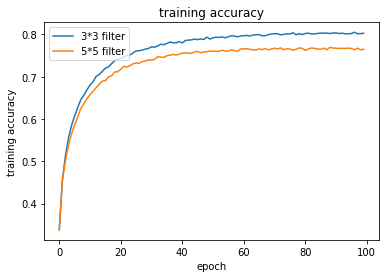

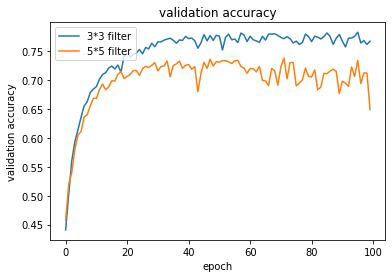

Test accuracy(3*3 filter): 0.7767999768257141
Test accuracy(5*5 filter): 0.7379999756813049


In [ ]:
# libraries (do not import additional libraries)
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint
import math
import matplotlib.pyplot as plt

# parameters for this script
batch_size = 32
num_classes = 10
epochs = 100
data_augmentation = False

# Load the data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# Define a convolutional neural network
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# initiate RMSprop optimizer
opt = keras.optimizers.RMSprop(lr=0.0001, decay=1e-6)

# Compile the model before using it
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
print(model.summary())
########################################

# Define a convolutional neural network
model5 = Sequential()
model5.add(Conv2D(32, (5, 5), padding='same',input_shape=x_train.shape[1:]))
model5.add(Activation('relu'))
model5.add(MaxPooling2D(pool_size=(2, 2)))
model5.add(Dropout(0.25))

model5.add(Conv2D(64, (5, 5), padding='same'))
model5.add(Activation('relu'))

model5.add(MaxPooling2D(pool_size=(2, 2)))
model5.add(Dropout(0.25))

model5.add(Flatten())
model5.add(Dense(512))
model5.add(Activation('relu'))
model5.add(Dropout(0.5))

model5.add(Dense(num_classes))
model5.add(Activation('softmax'))

# initiate RMSprop optimizer
opt5 = keras.optimizers.RMSprop(lr=0.0001, decay=1e-6)

# Compile the model before using it
model5.compile(loss='categorical_crossentropy',
              optimizer=opt5,
              metrics=['accuracy'])
print(model5.summary())
################################################3
# normalize the data
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

# partition training set into training and validation set
x_validate = x_train[40000:,:]
x_train = x_train[:40000,:]
y_validate = y_train[40000:,:]
y_train = y_train[:40000,:]

# create a callback that will save the best model while training
save_best_model = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', save_best_only=True, verbose=0)
save_best_model5 = ModelCheckpoint('best_model5.h5', monitor='val_accuracy', mode='max', save_best_only=True, verbose=0)

# train without data augmentation
if not data_augmentation:
    print('Not using data augmentation.')
    history = model.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_data=(x_validate, y_validate),
                        shuffle=True,
                        callbacks=[save_best_model],verbose=0)
    history5 = model5.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_data=(x_validate, y_validate),
                        shuffle=True,
                        callbacks=[save_best_model5],verbose=0)

# train with data augmentation
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    history = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
                        steps_per_epoch=math.ceil(x_train.shape[0]/batch_size),
                        epochs=epochs,
                        validation_data=(x_validate, y_validate),
                        callbacks=[save_best_model])
    
# Plot training accuracy
plt.plot(history.history['accuracy'],label='3*3 filter')
plt.plot(history5.history['accuracy'],label='5*5 filter')
plt.title('training accuracy')
plt.ylabel('training accuracy')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.show()

# Plot validation accuracy
plt.plot(history.history['val_accuracy'],label='3*3 filter')
plt.plot(history5.history['val_accuracy'],label='5*5 filter')
plt.title('validation accuracy')
plt.ylabel('validation accuracy')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.show()

# Evaluate the best model saved (i.e., model with best validation accuracy) on the test set
saved_model = load_model('best_model.h5')
saved_model5 = load_model('best_model5.h5')
scores = saved_model.evaluate(x_test, y_test, verbose=0)
scores5 = saved_model5.evaluate(x_test, y_test, verbose=0)
print('Test accuracy(3*3 filter):', scores[1])
print('Test accuracy(5*5 filter):', scores5[1])

**part1)**

as we can see convolutional neural network(CNN) has the best performance compared to  Dense networks. (in training ,testing and validation)

in contrast to fully connected networks where each neuron is connected to all nodes of  previous layer, CNNs are more sparse and they have shared weights. these shared weights take advantage of local similarities in input data and prevent number of parameters to grow very fast,and help easier generalization and optimizer can find  best weights to reduce loss more efficiently.

besides,in dense neural network for input data  with 512 nodes we get over 1M parameters only for the first layer,therefore increasing the depth of the network (which is often desirable for improving accuracy(given resources are available)) increases amount of parameters  fast which makes it very difficult for optimizer to find the best weights  .

furthurmore, one can see that as we increase the number of layers in dense neural network(not considering the network with  0 hidden layer), the accuracy decreases(in training,validation and testing). 

In theory, for training, if we increase number of epochs untill infinity , dense architectures with more hidden layers will eventually can perform at least as good as networks with less layers on training data.(although overfitting might lead to their worse performance in generalization steps.) its harder to train more complicated networks and thats why such behaviour is observed. 

it seems that optimizer fails to find  solution  within 20 epochs as we increase the number of layers/parameters. 

case of no hidden layer falls in between, on one hand it has simplicity which allows more optimal weight updating/assignment and on the other hand its not expressive enough. 

I increased number of epochs untill 100 and noticed that network with 0 hidden layer will eventually have the worst performance but the order of performance of other networks will remain the same even after 100 epochs meaning that:

accuracy of network with 1 hidden layer> 2 hidden layers>3 hidden layers>4 hidden layers .




**part 2)**as we can see in the plot, relu gives better performance compared to sigmoid. we can see that for the first few epochs we do not have any improvement with sigmoid activation

this is caused by gradient vanishing. gradient vanishing is more problematic for sigmoid. in this case it seems that gradient is close to 0 at starting point in case of sigmoid.


**part 3)**

we can see that in case of "no augmentation and no dropout" training is done the fastest. and it reaches 100% accuracy on training data however, in this case the generalization is the worst since it is overfitted. 

this behaviour is expected since  dataset is less complex. besides, layers with dropout have more difficulty fitting training data quickly. so when no augmentation and no dropout is involved training is done with highest speed


we can also see that data augmentation improves generalization and improves accuracy on testing while  we get a lower accuracy on training data which is expected behaviour. since augmentation increases the dataset and makes training more complex and at the same time more diverse dataset improves generalization.

also it can be noticed that dropout helps for generalization and accuracy on testing when no augmentation is done. when we have data augmentation, dropout  results in worse generalization compared to the situation when we have augmentation and no dropout. it can be interpretted that  effect of data augmentation will be reduced if we do not take advantage of all layers and use only subnetworks produced by dropout.



**part4)**
we can see that in training ,validation and also testing we get higher accuracy with Adam then with RMSprop and then with Adagrad

this is expected as mentioned in lecture 10 , Adagrad's learning rate decays too quickly (because of accumulation of sum of squared of partial derivatives and dividing learning rate by that)so weights eventuially  end up changing very little making progress very slowly.

RMSprop outperforms Adagrad  since it does not have the abovementioned problem(it has the capability of assigning weight to squared of partial derivatives so that recent gradients are taken into account more) 

but it lacks  gradient momentom(problematic in regions where gradient is small and stable) which is the reason why Adam outperforms it since it takes into acount weighted moving average of gradients and moves accordingly in that direction during weight updates .



**part5)**

as we can see network with more layers with  3 by 3 filter  outperforms  network with fewer layers with 5 by 5 filter in training,validation and testing.

the deeper architecture with smaller kernel size has more parameters therefore it's more expressive and it can fit data better.
the higher layers of deeper network in image classification detects more complex features.Increasing the kernel size might help depending on characteristics of images(for example if the features are not localized) but more complex features are identified in deeper layers while first layers identify general simple features such as edges,etc.

